## Identify drivers affecting outcomes

In [128]:
%matplotlib inline


In [129]:
import pandas as pd
data = pd.read_csv(
    "barley_yield_from_1982.csv",
    sep=";"
)

data = data.loc[:, ~data.columns.str.contains("^Unnamed")]
data

,department,year,yield,area,production
0,Ain,1982,3.95008,16065.0,63458.00
1,Ain,1983,NaN,14500.0,38400.00
2,Ain,1984,4.82258,15500.0,74750.00
3,Ain,1985,4.19677,15500.0,65050.00
4,Ain,1986,3.59845,12900.0,46420.00
...,...,...,...,...,...
3578,Yvelines,2014,7.70000,10180.0,78546.00
3579,Yvelines,2015,8.00000,11420.0,91400.50
3580,Yvelines,2016,NaN,12225.0,64792.50
3581,Yvelines,2017,7.31000,13735.0,100402.85


In [130]:
import pandas as pd
climate = pd.read_parquet(
    "climate_data_from_1982.parquet"
)
climate

,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,2.762923e+02
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,2.750924e+02
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,2.764185e+02
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,2.788934e+02
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,2.788872e+02
...,...,...,...,...,...,...,...
1170256,ssp5_8_5,Yvelines,78,2050-12-27 12:00:00,2050,precipitation,3.356686e-05
1170257,ssp5_8_5,Yvelines,78,2050-12-28 12:00:00,2050,precipitation,3.531645e-06
1170258,ssp5_8_5,Yvelines,78,2050-12-29 12:00:00,2050,precipitation,4.072561e-06
1170259,ssp5_8_5,Yvelines,78,2050-12-30 12:00:00,2050,precipitation,4.087608e-09


In [131]:
import pandas as pd

YIELD_PATH = "barley_yield_from_1982.csv"
WEATHER_PATH = "climate_data_from_1982.parquet"

yield_df = pd.read_csv(YIELD_PATH, sep=";")
weather = pd.read_parquet(WEATHER_PATH)

yield_df = yield_df.loc[:, ~yield_df.columns.str.contains(r"^Unnamed", na=False)].copy()

yield_df["year"] = yield_df["year"].astype(int)
weather["year"] = weather["year"].astype(int)

yield_df["department"] = yield_df["department"].astype(str).str.strip()
weather["nom_dep"] = weather["nom_dep"].astype(str).str.strip()

metrics = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature",
    "precipitation",
]
weather = weather[weather["metric"].isin(metrics)].copy()

temp_mask = weather["metric"].str.contains("temperature", na=False)
weather.loc[temp_mask, "value"] = weather.loc[temp_mask, "value"] - 273.15

prec_mask = weather["metric"] == "precipitation"
weather.loc[prec_mask, "value"] = weather.loc[prec_mask, "value"] * 1000

weather["time"] = pd.to_datetime(weather["time"])

weather_daily = (
    weather.pivot_table(
        index=["nom_dep", "time", "year", "scenario"], 
    
        columns="metric",
        values="value",
        aggfunc="mean" 
    
    )
    .reset_index()
)

weather_daily = weather_daily.rename(columns={
    "nom_dep": "department",
    "near_surface_air_temperature": "temp_C",
    "daily_maximum_near_surface_air_temperature": "max_temp_C",
    "precipitation": "precip_mm",
})

merged_daily = pd.merge(
    weather_daily,
    yield_df,
    on=["department", "year"],
    how="left"  

)

print("weather_daily shape:", weather_daily.shape)
print("merged_daily shape:", merged_daily.shape)

if "yield" in merged_daily.columns:
    print("Share of daily rows with missing yield:", merged_daily["yield"].isna().mean())

print(merged_daily.head())



/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/4113585178.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.14226685  1.94240723  3.26851807 ... 12.10500488 11.59530029
 13.85772095]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  weather.loc[temp_mask, "value"] = weather.loc[temp_mask, "value"] - 273.15


weather_daily shape: (4583500, 7)
merged_daily shape: (4583500, 10)
Share of daily rows with missing yield: 0.6944852187193193
  department                time  year    scenario  max_temp_C    temp_C  \
0        Ain 1982-01-01 12:00:00  1982  historical    6.187311  3.142267   
1        Ain 1982-01-02 12:00:00  1982  historical    4.537225  1.942407   
2        Ain 1982-01-03 12:00:00  1982  historical    5.238794  3.268518   
3        Ain 1982-01-04 12:00:00  1982  historical   10.369043  5.743372   
4        Ain 1982-01-05 12:00:00  1982  historical    7.972253  5.737207   

   precip_mm    yield     area  production  
0   0.032987  3.95008  16065.0     63458.0  
1   0.139467  3.95008  16065.0     63458.0  
2   0.090612  3.95008  16065.0     63458.0  
3   0.056591  3.95008  16065.0     63458.0  
4   0.257024  3.95008  16065.0     63458.0  


In [132]:
hist = merged_daily[merged_daily["scenario"] == "historical"].copy()


In [133]:
climate_yearly = (
    hist.groupby(["department", "year"])
    .agg(
        avg_temp=("temp_C", "mean"),
        max_temp=("max_temp_C", "max"),
        total_precip=("precip_mm", "sum"),
        heat_days=("max_temp_C", lambda x: (x > 30).sum()),
        dry_days=("precip_mm", lambda x: (x < 1).sum())
    )
    .reset_index()
)

threshold = climate_yearly["total_precip"].quantile(0.1)

climate_yearly["drought_year"] = climate_yearly["total_precip"] < threshold


In [134]:
yield_yearly = hist[["department", "year", "yield"]].drop_duplicates()

climate_yearly = climate_yearly.merge(
    yield_yearly,
    on=["department", "year"],
    how="left"
)


In [135]:
climate_yearly

,department,year,avg_temp,max_temp,total_precip,heat_days,dry_days,drought_year,yield
0,Ain,1982,9.629243,32.390894,27.494342,6,365,False,3.95008
1,Ain,1983,8.574003,28.897577,29.012420,0,365,False,NaN
2,Ain,1984,8.904192,29.287683,27.781132,0,366,False,4.82258
3,Ain,1985,8.529637,28.598352,34.205864,0,365,False,4.19677
4,Ain,1986,9.271484,30.829248,23.954829,2,365,False,3.59845
...,...,...,...,...,...,...,...,...,...
2932,Yvelines,2010,12.099465,34.342920,8.072196,30,365,True,7.03784
2933,Yvelines,2011,11.614076,35.087122,10.917476,12,365,True,6.15587
2934,Yvelines,2012,10.961691,35.820398,9.088743,17,366,True,7.67549
2935,Yvelines,2013,12.272734,34.787225,9.660494,24,365,True,7.04382


## Identify drivers affecting outcomes

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

hist = merged_daily[merged_daily["scenario"] == "historical"].copy()

climate_yearly = (
    hist.groupby(["department", "year"])
    .agg(
        avg_temp=("temp_C", "mean"),
        max_temp=("max_temp_C", "max"),
        total_precip=("precip_mm", "sum"),
        heat_days=("max_temp_C", lambda x: (x > 30).sum()),
        extreme_heat_days=("max_temp_C", lambda x: (x > 35).sum()),
        dry_days=("precip_mm", lambda x: (x < 0.003).sum()), 
        rainfall_variability=("precip_mm", "std"),         
    )
    .reset_index()
)

threshold = climate_yearly["total_precip"].quantile(0.1)
climate_yearly["drought_year"] = climate_yearly["total_precip"] < threshold

yield_yearly = hist[["department", "year", "yield"]].drop_duplicates()

climate_yearly = climate_yearly.merge(
    yield_yearly,
    on=["department", "year"],
    how="left"
)

print("\nCorrelation with yield:")
print(climate_yearly.corr(numeric_only=True)["yield"].sort_values())


Correlation with yield:
rainfall_variability   -0.312510
total_precip           -0.201019
dry_days               -0.122845
extreme_heat_days       0.085273
drought_year            0.097753
avg_temp                0.171833
heat_days               0.194017
max_temp                0.374915
year                    0.378888
yield                   1.000000
Name: yield, dtype: float64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/443846604.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_heat = climate_yearly.groupby(heat_bins)["yield"].mean()


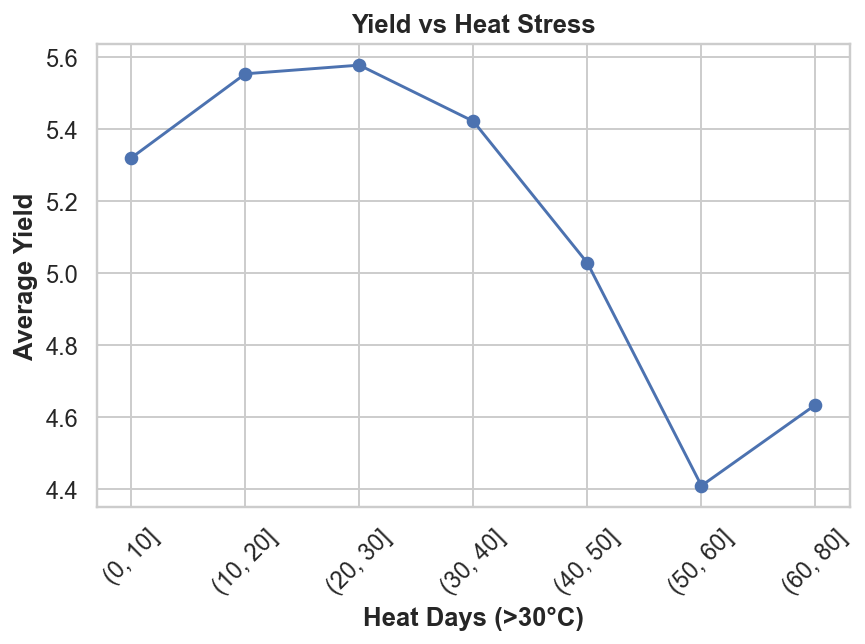

In [137]:
# (A) Yield vs heat stress
heat_bins = pd.cut(climate_yearly["heat_days"], bins=[0,10,20,30,40,50,60,80])
yield_heat = climate_yearly.groupby(heat_bins)["yield"].mean()

yield_heat.plot(marker="o")
plt.title("Yield vs Heat Stress")
plt.xlabel("Heat Days (>30°C)")
plt.ylabel("Average Yield")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/2558841303.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_rain = climate_yearly.groupby(rain_bins)["yield"].mean()


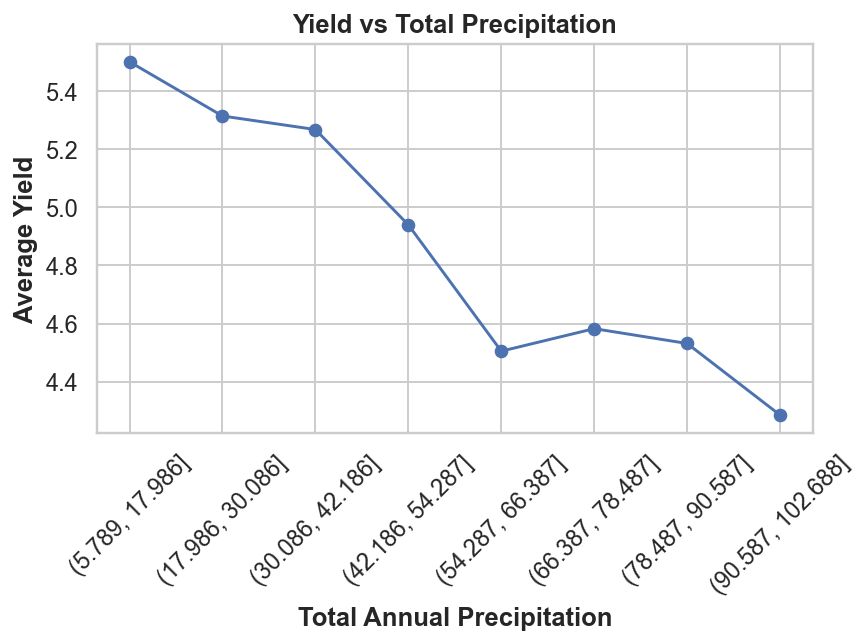

In [138]:
# (B) Yield vs total precipitation
rain_bins = pd.cut(climate_yearly["total_precip"], bins=8)
yield_rain = climate_yearly.groupby(rain_bins)["yield"].mean()

yield_rain.plot(marker="o")
plt.title("Yield vs Total Precipitation")
plt.xlabel("Total Annual Precipitation")
plt.ylabel("Average Yield")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/1220947453.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_extreme = climate_yearly.groupby(extreme_bins)["yield"].mean()


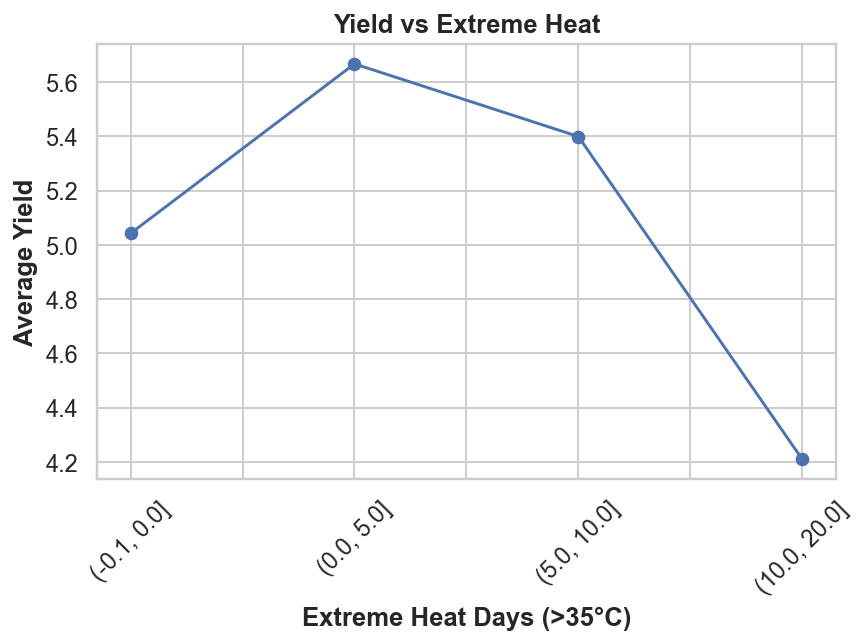

In [139]:

# (C) Yield vs extreme heat
extreme_bins = pd.cut(climate_yearly["extreme_heat_days"], bins=[-0.1,0,5,10,20,50])
yield_extreme = climate_yearly.groupby(extreme_bins)["yield"].mean()

yield_extreme.plot(marker="o")
plt.title("Yield vs Extreme Heat")
plt.xlabel("Extreme Heat Days (>35°C)")
plt.ylabel("Average Yield")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/1068607360.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_dry = climate_yearly.groupby(dry_bins)["yield"].mean()


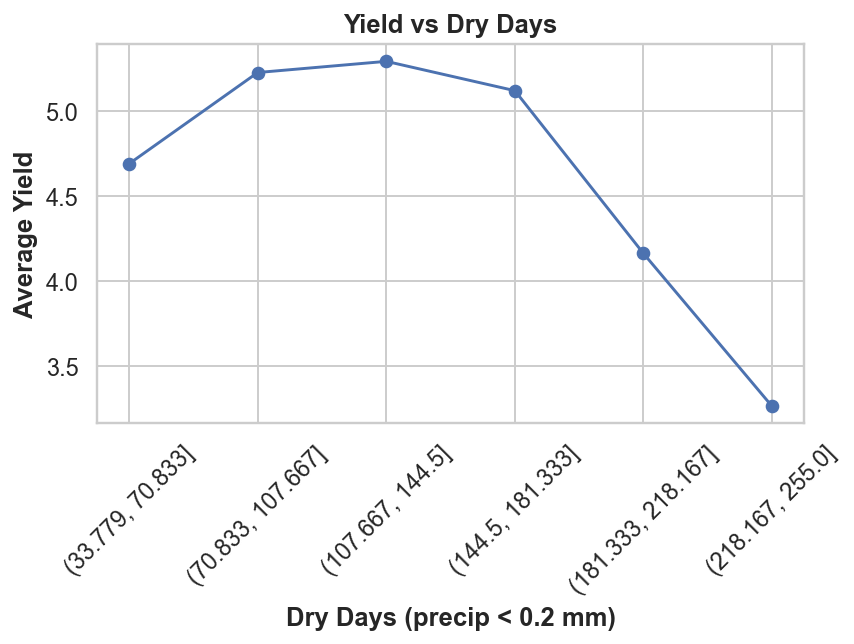

In [140]:
# (D) Yield vs dryness (improved dry day definition)
dry_bins = pd.cut(climate_yearly["dry_days"], bins=6)
yield_dry = climate_yearly.groupby(dry_bins)["yield"].mean()

yield_dry.plot(marker="o")
plt.title("Yield vs Dry Days")
plt.xlabel("Dry Days (precip < 0.2 mm)")
plt.ylabel("Average Yield")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_87658/2925892510.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_rv = climate_yearly.groupby(rv_bins)["yield"].mean()


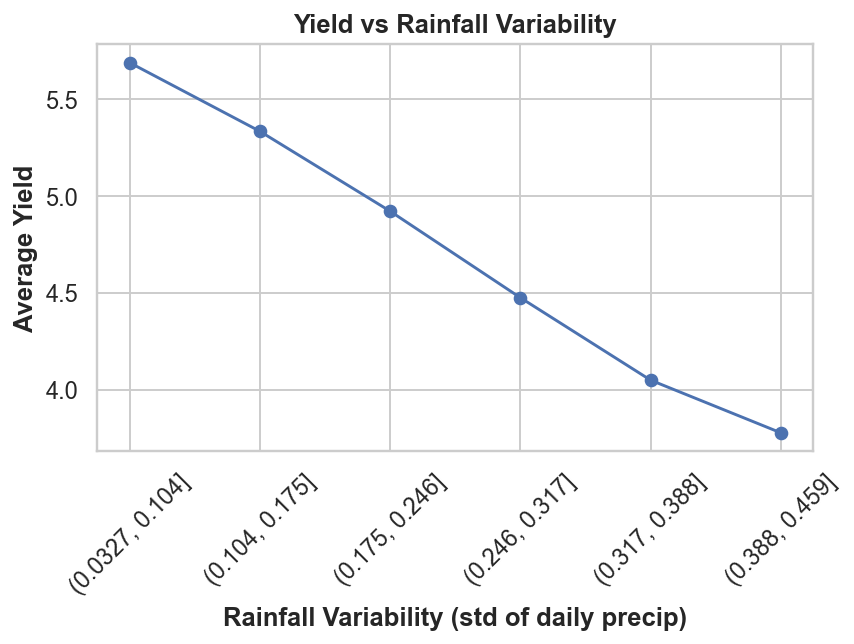

In [141]:
# (E) Yield vs rainfall variability
rv_bins = pd.cut(climate_yearly["rainfall_variability"], bins=6)
yield_rv = climate_yearly.groupby(rv_bins)["yield"].mean()

yield_rv.plot(marker="o")
plt.title("Yield vs Rainfall Variability")
plt.xlabel("Rainfall Variability (std of daily precip)")
plt.ylabel("Average Yield")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


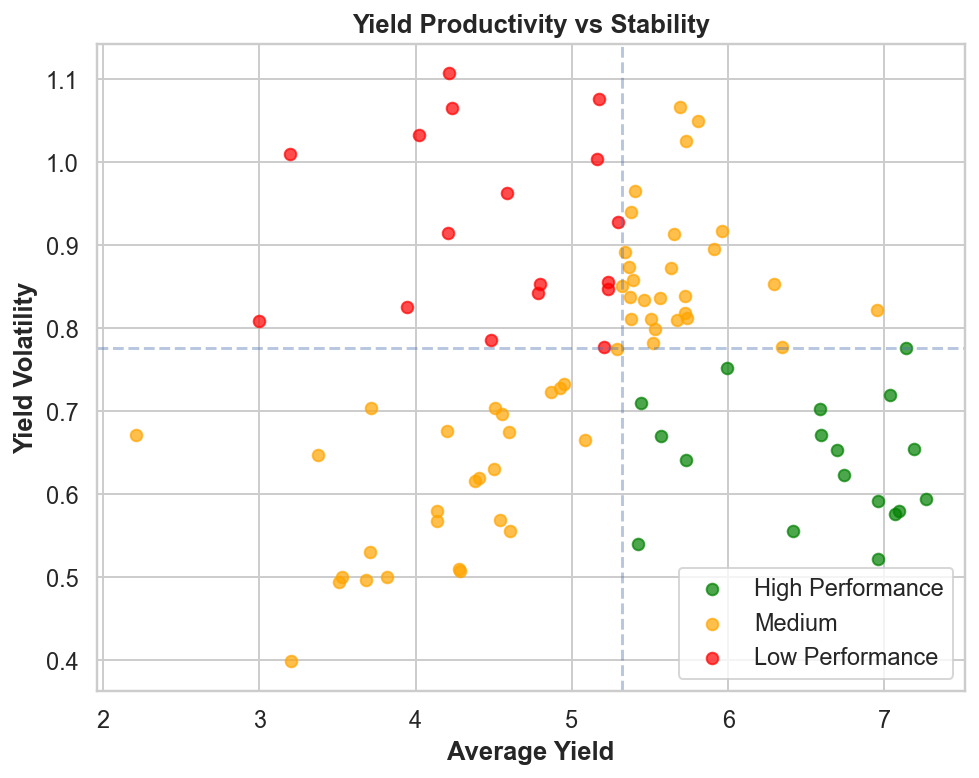

In [142]:
# (F) Region-level yield productivity vs stability
import matplotlib.pyplot as plt

region_stats = climate_yearly.groupby("department").agg(
    avg_yield=("yield","mean"),
    volatility=("yield","std")
)

yield_median = region_stats["avg_yield"].median()
vol_median = region_stats["volatility"].median()

def classify(row):
    if row["avg_yield"] >= yield_median and row["volatility"] <= vol_median:
        return "High Performance"
    elif row["avg_yield"] < yield_median and row["volatility"] > vol_median:
        return "Low Performance"
    else:
        return "Medium"

region_stats["category"] = region_stats.apply(classify, axis=1)

colors = {
    "High Performance": "green",
    "Medium": "orange",
    "Low Performance": "red"
}

plt.figure(figsize=(8,6))

for cat, color in colors.items():
    subset = region_stats[region_stats["category"] == cat]
    plt.scatter(
        subset["avg_yield"],
        subset["volatility"],
        label=cat,
        color=color,
        alpha=0.7
    )

plt.axvline(yield_median, linestyle="--", alpha=0.4)
plt.axhline(vol_median, linestyle="--", alpha=0.4)

plt.title("Yield Productivity vs Stability")
plt.xlabel("Average Yield")
plt.ylabel("Yield Volatility")
plt.legend()
plt.show()


In [143]:
region_stats = climate_yearly.groupby("department").agg(
    avg_yield=("yield","mean"),
    volatility=("yield","std")
)

norm = (region_stats - region_stats.min()) / (region_stats.max() - region_stats.min())

norm["score"] = norm["avg_yield"] + (1 - norm["volatility"])

top10_good = norm.sort_values("score", ascending=False).head(10)

top10_good


,avg_yield,volatility,score
department,,,
Aisne,0.940107,0.174067,1.766041
Somme,1.000000,0.276915,1.723085
Seine_Maritime,0.966631,0.256023,1.710609
Oise,0.960948,0.250411,1.710537
Marne,0.939709,0.272183,1.667526
Pas_de_Calais,0.985096,0.360487,1.624610
Ardennes,0.832604,0.221894,1.610710
Aube,0.896242,0.316148,1.580095
Calvados,0.887386,0.360141,1.527245


In [144]:
import numpy as np
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 200,
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
})

# Department-level summary from climate_yearly
dept = (
    climate_yearly.groupby("department")["yield"]
    .agg(avg_yield="mean", volatility="std", count="count")
    .reset_index()
)

# Performance tiers (terciles)
dept["tier"] = pd.qcut(
    dept["avg_yield"], q=3,
    labels=["Low Performance", "Medium", "High Performance"],
)

TIER_COLORS = {
    "Low Performance": "#EF4444",
    "Medium": "#F59E0B",
    "High Performance": "#16A34A",
}
TIERS = ["Low Performance", "Medium", "High Performance"]

dept.head()


,department,avg_yield,volatility,count,tier
0,Ain,5.364686,0.873244,31,Medium
1,Aisne,6.960607,0.521745,32,High Performance
2,Allier,4.794422,0.853148,33,Medium
3,Alpes_Maritimes,3.193572,1.010137,32,Low Performance
4,Alpes_de_Haute_Provence,3.680187,0.496420,33,Low Performance


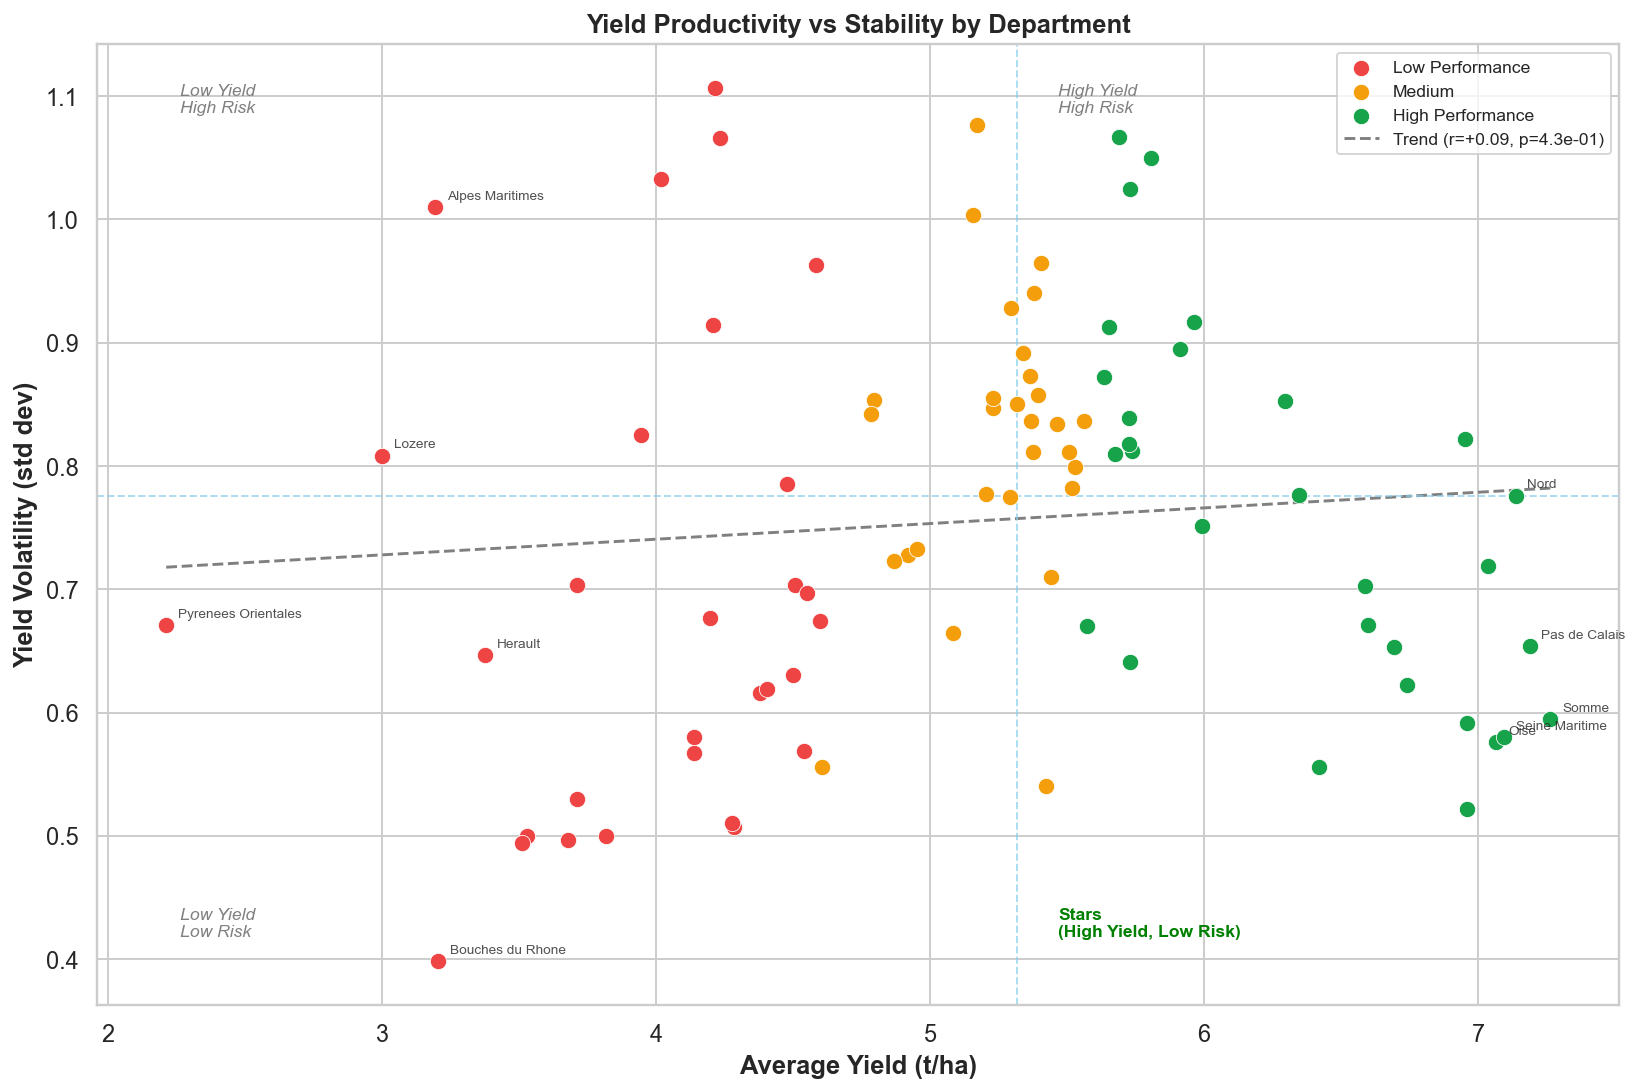

In [145]:
# Enhanced Productivity vs Stability scatter
fig, ax = plt.subplots(figsize=(12, 8))

for tier in TIERS:
    sub = dept[dept["tier"] == tier]
    ax.scatter(
        sub["avg_yield"], sub["volatility"],
        c=TIER_COLORS[tier], label=tier,
        s=70, edgecolors="white", linewidths=0.4, zorder=3,
    )

# Regression trendline
slope, intercept, r, p, _ = stats.linregress(dept["avg_yield"], dept["volatility"])
xr = np.linspace(dept["avg_yield"].min(), dept["avg_yield"].max(), 100)
ax.plot(xr, intercept + slope * xr, "--", color="grey", linewidth=1.5,
        label=f"Trend (r={r:+.2f}, p={p:.1e})")

# Median reference lines
med_y = dept["avg_yield"].median()
med_v = dept["volatility"].median()
ax.axvline(med_y, ls="--", color="skyblue", lw=1, alpha=0.7)
ax.axhline(med_v, ls="--", color="skyblue", lw=1, alpha=0.7)

# Quadrant labels
ax.text(med_y + 0.15, dept["volatility"].max() - 0.02, "High Yield\nHigh Risk",
        fontsize=9, color="grey", style="italic")
ax.text(dept["avg_yield"].min() + 0.05, dept["volatility"].max() - 0.02,
        "Low Yield\nHigh Risk", fontsize=9, color="grey", style="italic")
ax.text(med_y + 0.15, dept["volatility"].min() + 0.02, "Stars\n(High Yield, Low Risk)",
        fontsize=9, color="green", weight="bold")
ax.text(dept["avg_yield"].min() + 0.05, dept["volatility"].min() + 0.02,
        "Low Yield\nLow Risk", fontsize=9, color="grey", style="italic")

# Label top-5 and bottom-5 departments
top5 = dept.nlargest(5, "avg_yield")
bot5 = dept.nsmallest(5, "avg_yield")
for _, row in pd.concat([top5, bot5]).iterrows():
    ax.annotate(
        row["department"].replace("_", " "),
        (row["avg_yield"], row["volatility"]),
        fontsize=7, alpha=0.8,
        textcoords="offset points", xytext=(6, 4),
    )

ax.set_xlabel("Average Yield (t/ha)")
ax.set_ylabel("Yield Volatility (std dev)")
ax.set_title("Yield Productivity vs Stability by Department")
ax.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.show()


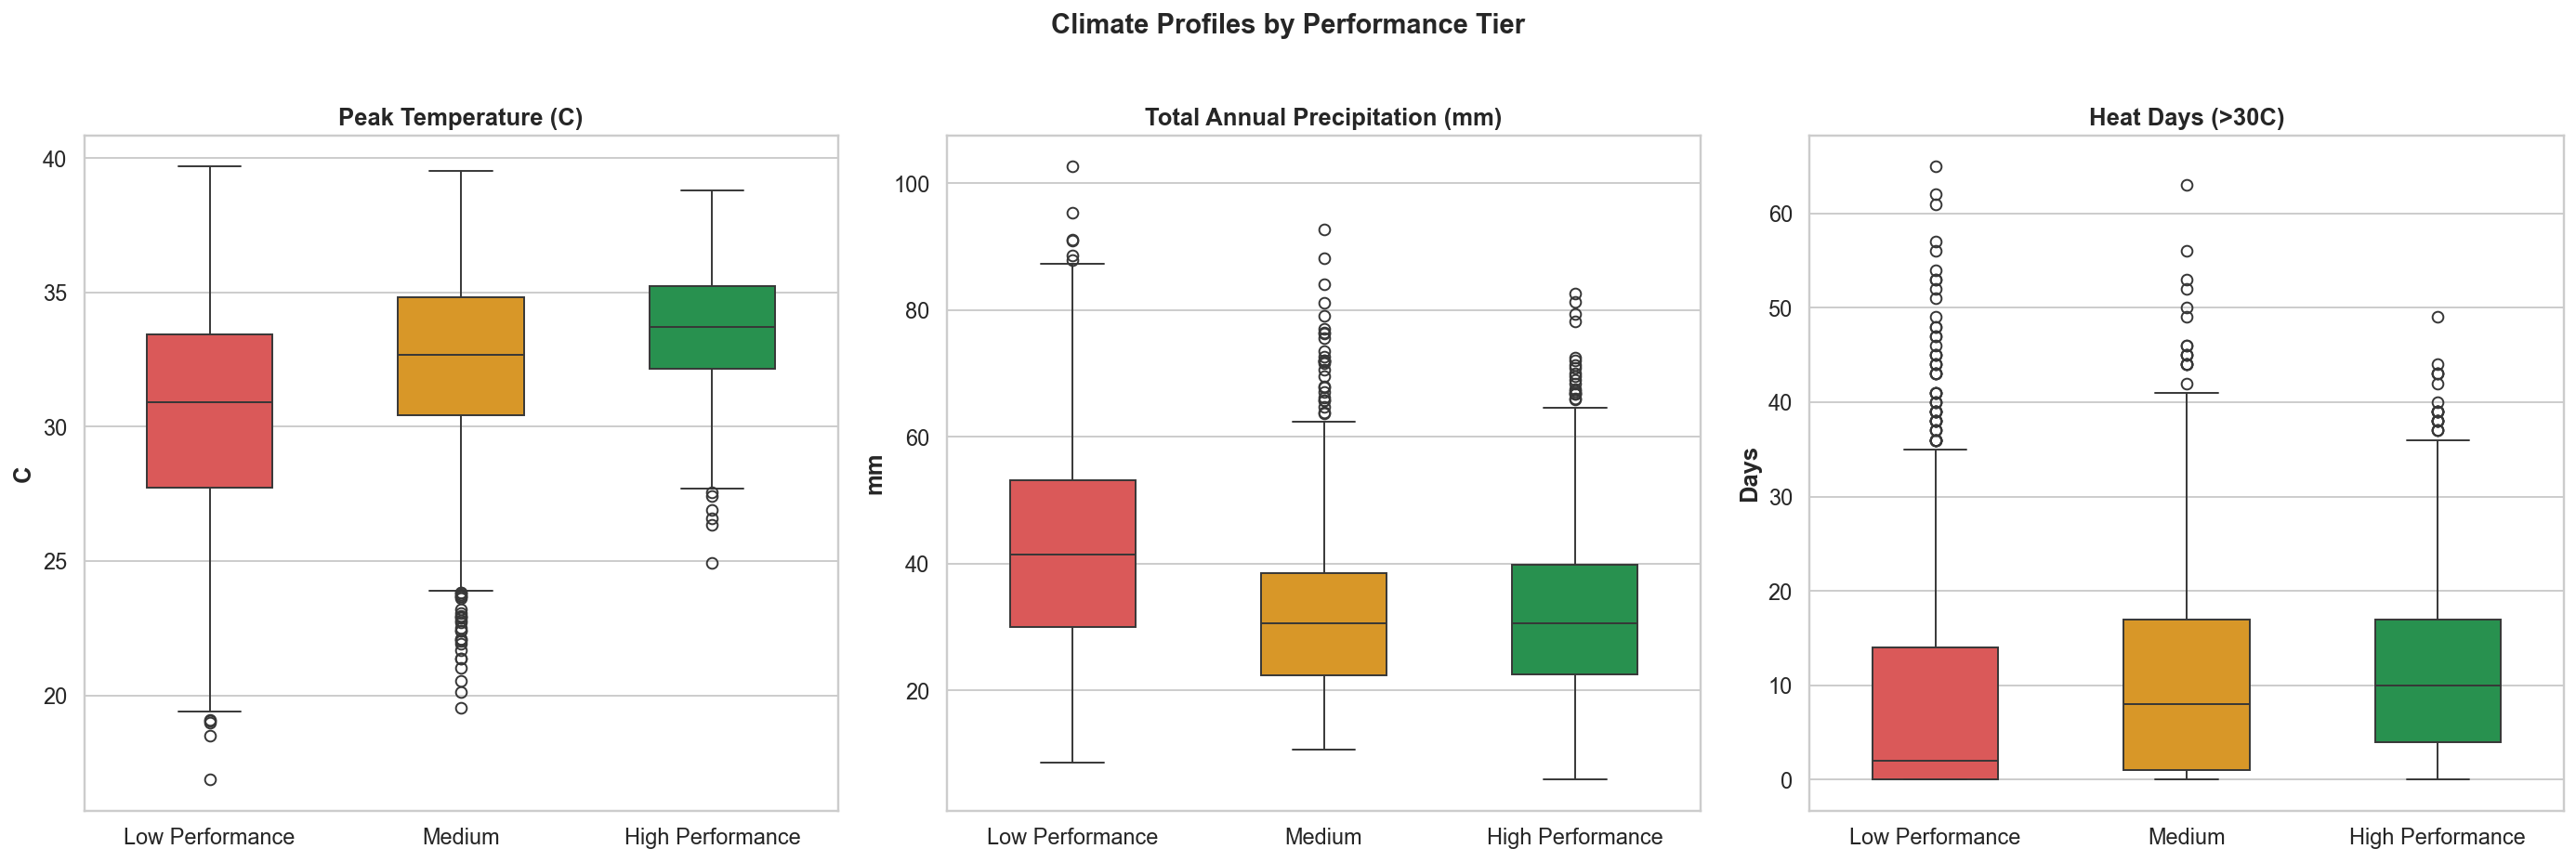

Climate summary by tier:

  LOW PERFORMANCE (30 depts)
    Mean max temp    : 30.5 C
    Mean precip      : 42.2 mm
    Mean heat days   : 8.8
    Mean yield       : 3.97 t/ha
    Yield CV         : 22.7%

  MEDIUM (29 depts)
    Mean max temp    : 32.2 C
    Mean precip      : 31.9 mm
    Mean heat days   : 10.9
    Mean yield       : 5.24 t/ha
    Yield CV         : 16.2%

  HIGH PERFORMANCE (30 depts)
    Mean max temp    : 33.6 C
    Mean precip      : 31.3 mm
    Mean heat days   : 11.7
    Mean yield       : 6.31 t/ha
    Yield CV         : 15.2%


In [146]:
# Climate profiles by performance tier
df_tier = climate_yearly.merge(dept[["department", "tier"]], on="department", how="left")

fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))

# Peak temperature
sns.boxplot(data=df_tier, x="tier", y="max_temp", order=TIERS, hue="tier",
            palette=TIER_COLORS, width=0.5, ax=axes[0], legend=False)
axes[0].set_title("Peak Temperature (C)")
axes[0].set_xlabel("")
axes[0].set_ylabel("C")

# Total precipitation
sns.boxplot(data=df_tier, x="tier", y="total_precip", order=TIERS, hue="tier",
            palette=TIER_COLORS, width=0.5, ax=axes[1], legend=False)
axes[1].set_title("Total Annual Precipitation (mm)")
axes[1].set_xlabel("")
axes[1].set_ylabel("mm")

# Heat days
sns.boxplot(data=df_tier, x="tier", y="heat_days", order=TIERS, hue="tier",
            palette=TIER_COLORS, width=0.5, ax=axes[2], legend=False)
axes[2].set_title("Heat Days (>30C)")
axes[2].set_xlabel("")
axes[2].set_ylabel("Days")

fig.suptitle("Climate Profiles by Performance Tier", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Stats
print("Climate summary by tier:")
for tier in TIERS:
    sub = df_tier[df_tier["tier"] == tier]
    print(f"\n  {tier.upper()} ({sub['department'].nunique()} depts)")
    print(f"    Mean max temp    : {sub['max_temp'].mean():.1f} C")
    print(f"    Mean precip      : {sub['total_precip'].mean():.1f} mm")
    print(f"    Mean heat days   : {sub['heat_days'].mean():.1f}")
    print(f"    Mean yield       : {sub['yield'].mean():.2f} t/ha")
    print(f"    Yield CV         : {sub['yield'].std()/sub['yield'].mean()*100:.1f}%")


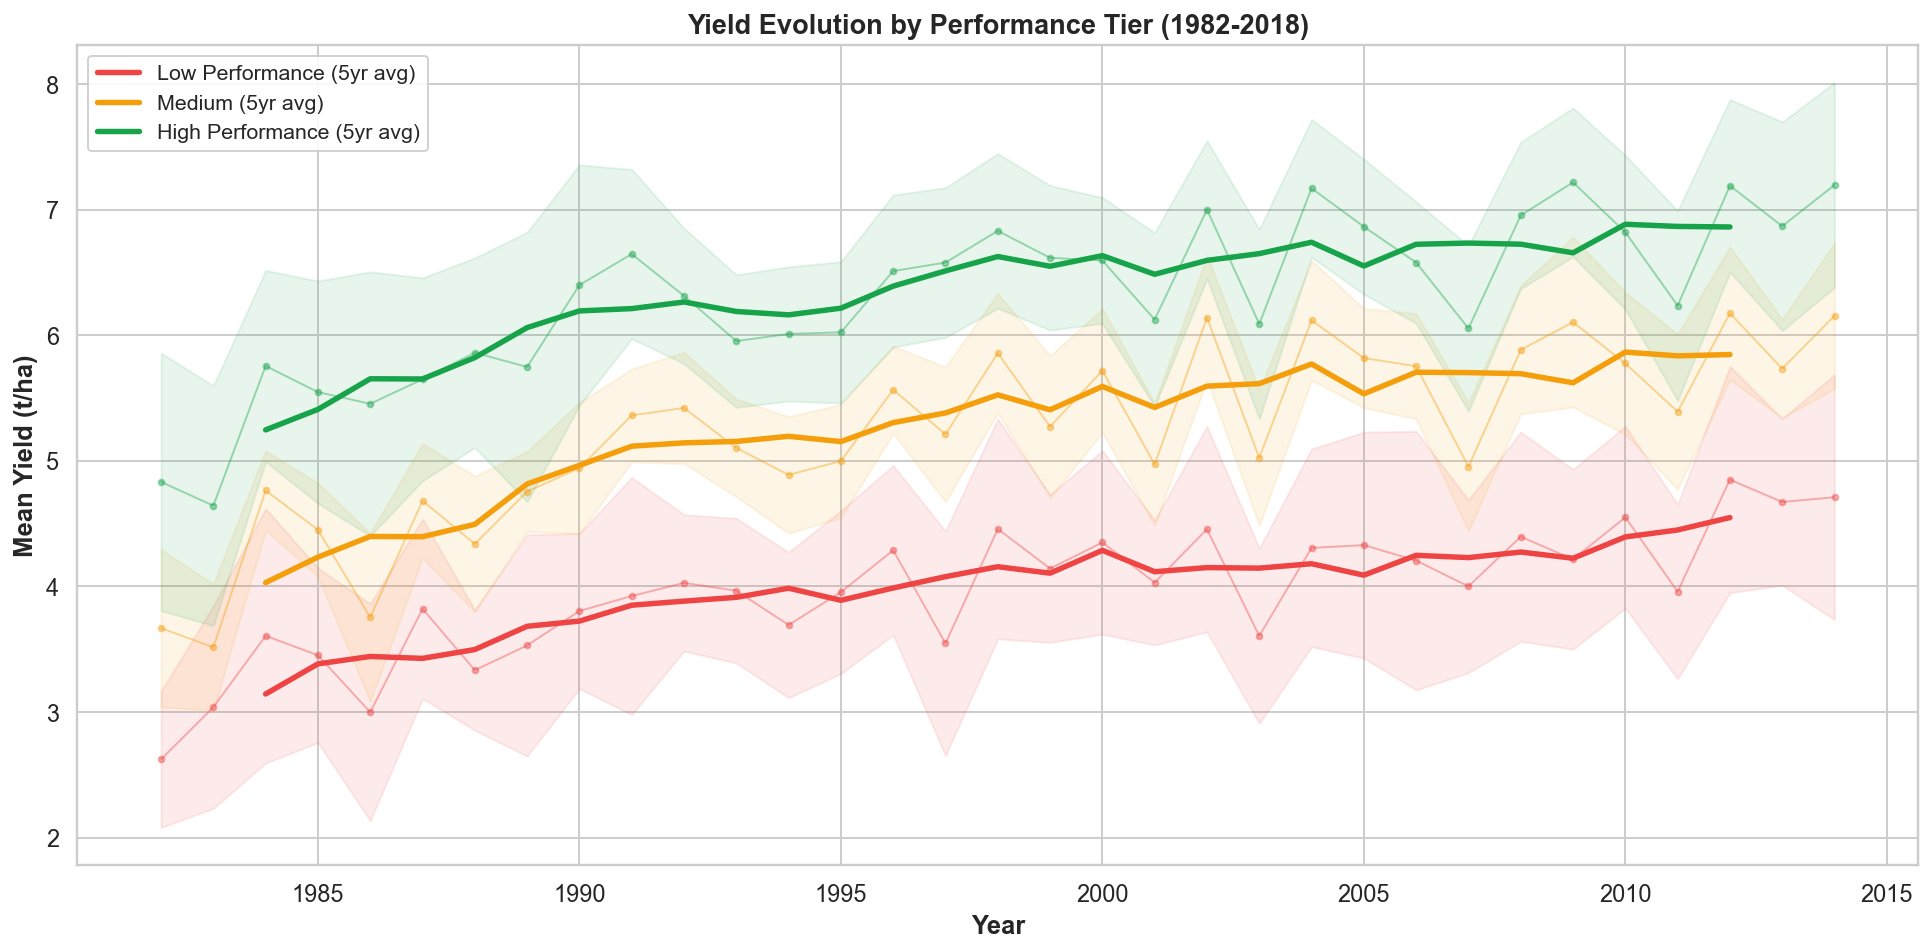

In [147]:
# Yield evolution by performance tier (time series)
fig, ax = plt.subplots(figsize=(14, 7))

for tier in TIERS:
    yearly = (
        df_tier[df_tier["tier"] == tier]
        .groupby("year")["yield"]
        .agg(["mean", "std"])
        .reset_index()
    )
    yearly["roll"] = yearly["mean"].rolling(5, center=True).mean()
    color = TIER_COLORS[tier]
    ax.fill_between(yearly["year"],
                    yearly["mean"] - yearly["std"],
                    yearly["mean"] + yearly["std"],
                    alpha=0.1, color=color)
    ax.plot(yearly["year"], yearly["mean"], "o-", markersize=3,
            linewidth=1, color=color, alpha=0.4)
    ax.plot(yearly["year"], yearly["roll"], linewidth=2.8,
            color=color, label=f"{tier} (5yr avg)")

ax.set_title("Yield Evolution by Performance Tier (1982-2018)", fontsize=14, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Yield (t/ha)")
ax.legend(fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.show()


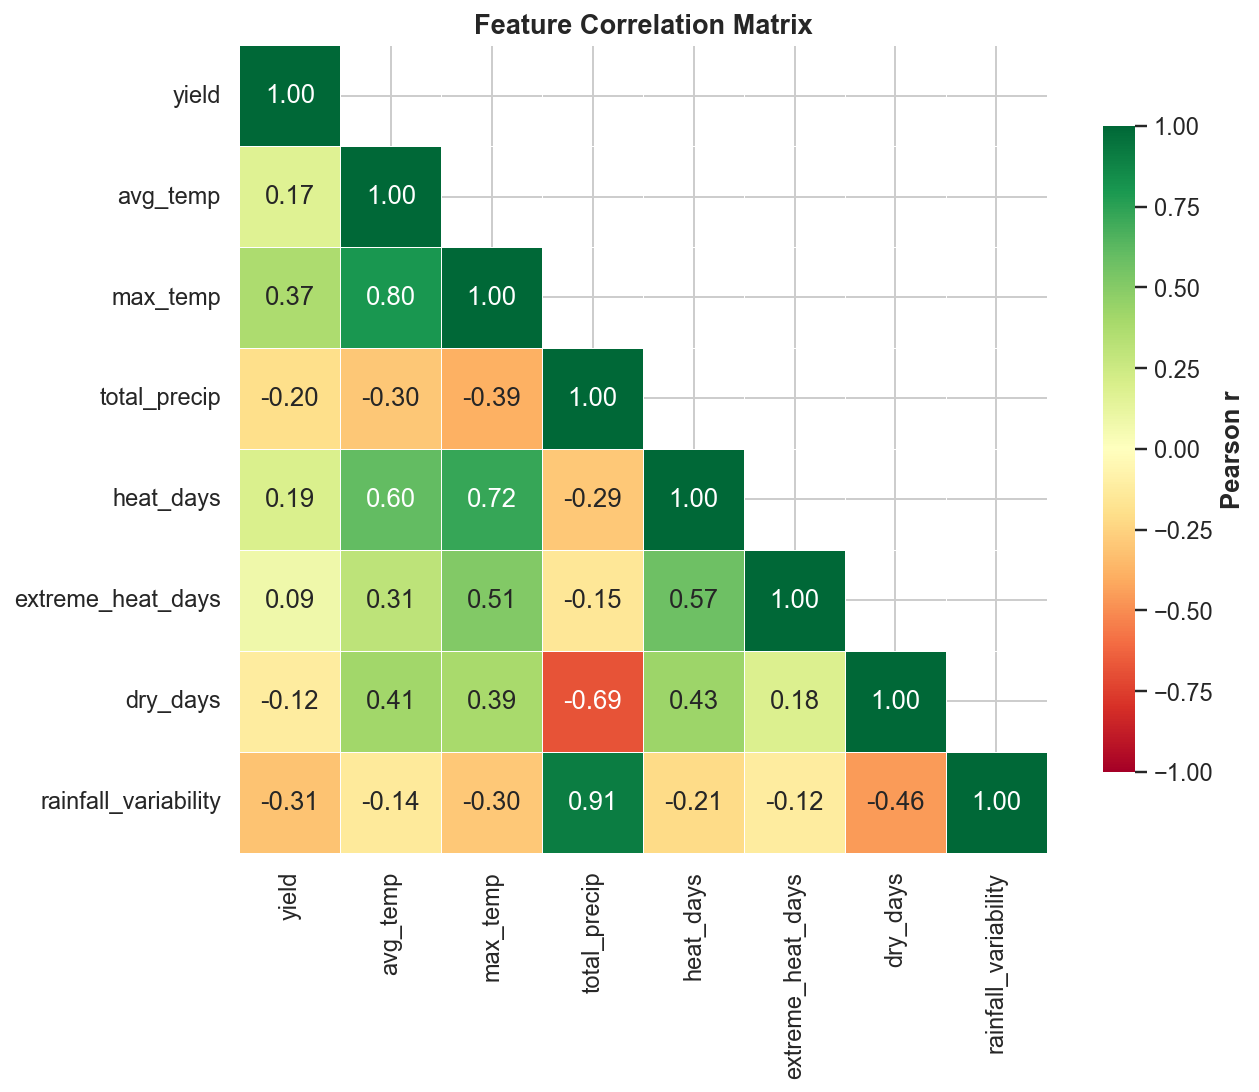

In [148]:
# Correlation heatmap
corr_cols = [
    "yield", "avg_temp", "max_temp", "total_precip",
    "heat_days", "extreme_heat_days", "dry_days",
    "rainfall_variability",
]
corr = climate_yearly[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f", cmap="RdYlGn",
    center=0, vmin=-1, vmax=1, linewidths=0.5,
    ax=ax, square=True,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
)
ax.set_title("Feature Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


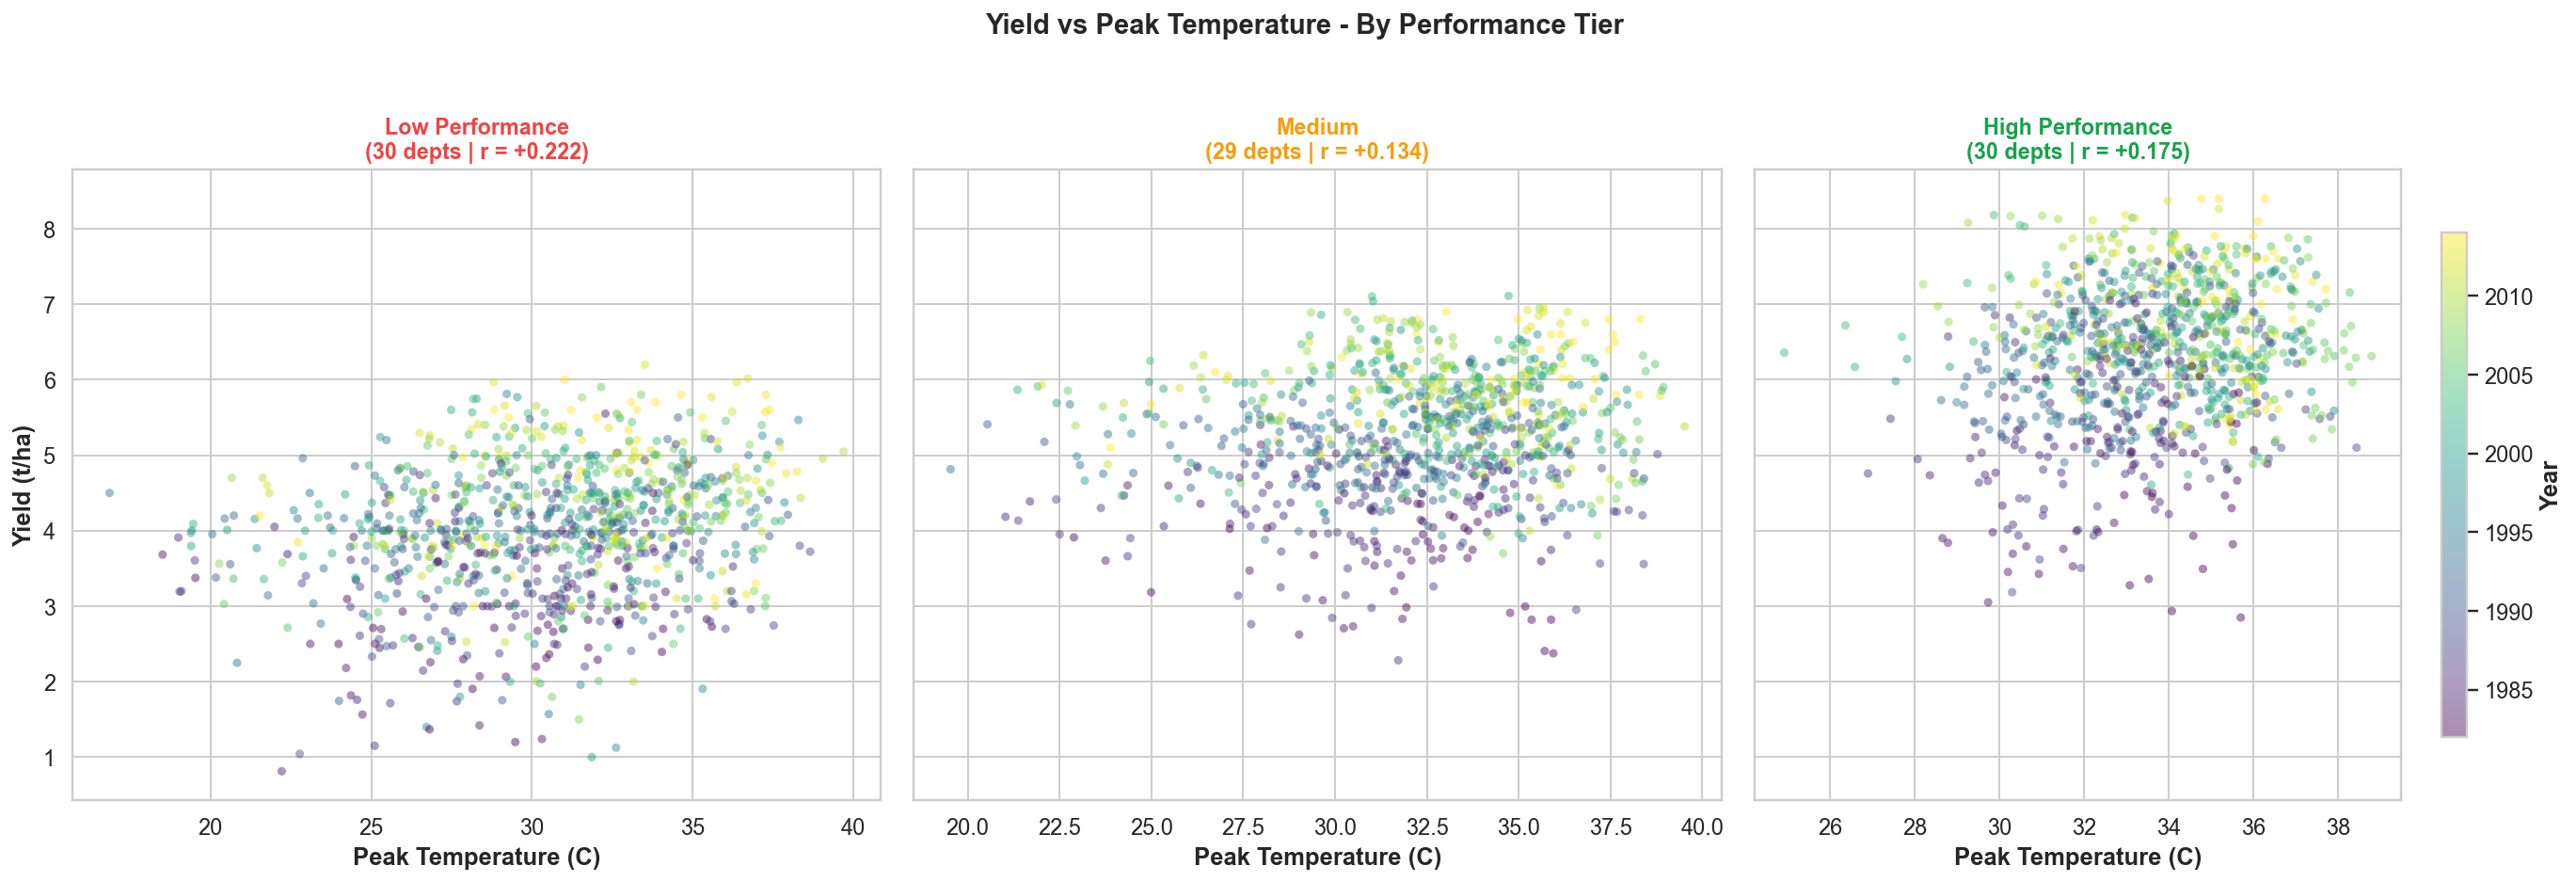

In [149]:
# Yield vs Peak Temperature within each tier
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5), sharey=True)

for ax, tier in zip(axes, TIERS):
    sub = df_tier[df_tier["tier"] == tier]
    color = TIER_COLORS[tier]
    scatter = ax.scatter(sub["max_temp"], sub["yield"],
                         c=sub["year"], cmap="viridis",
                         alpha=0.45, s=22, edgecolors="none")
    z = np.polyfit(sub["max_temp"], sub["yield"], 1)
    xr = np.linspace(sub["max_temp"].min(), sub["max_temp"].max(), 100)
    ax.plot(xr, np.poly1d(z)(xr), "--", linewidth=2.5, color=color)
    r = sub["max_temp"].corr(sub["yield"])
    ax.set_title(f"{tier}\n({sub['department'].nunique()} depts | r = {r:+.3f})",
                 fontsize=12, color=color)
    ax.set_xlabel("Peak Temperature (C)")
    if ax == axes[0]:
        ax.set_ylabel("Yield (t/ha)")
    if ax == axes[-1]:
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label("Year")

fig.suptitle("Yield vs Peak Temperature - By Performance Tier",
             fontsize=15, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()


  TOP & BOTTOM DEPARTMENTS PER TIER

  LOW PERFORMANCE (median yield: 4.17 t/ha)
    Best 3:
      Gers                            yield=4.60  vol=0.67
      Loire                           yield=4.58  vol=0.96
      Pyrenees_Atlantiques            yield=4.55  vol=0.70
    Worst 3:
      Pyrenees_Orientales             yield=2.21  vol=0.67
      Lozere                          yield=3.00  vol=0.81
      Alpes_Maritimes                 yield=3.19  vol=1.01

  MEDIUM (median yield: 5.32 t/ha)
    Best 3:
      Nievre                          yield=5.56  vol=0.84
      Bas_Rhin                        yield=5.53  vol=0.80
      Haut_Rhin                       yield=5.52  vol=0.78
    Worst 3:
      Haute_Garonne                   yield=4.60  vol=0.56
      Lot_et_Garonne                  yield=4.79  vol=0.84
      Allier                          yield=4.79  vol=0.85

  HIGH PERFORMANCE (median yield: 6.32 t/ha)
    Best 3:
      Somme                           yield=7.26  vol=0.59
      Pa

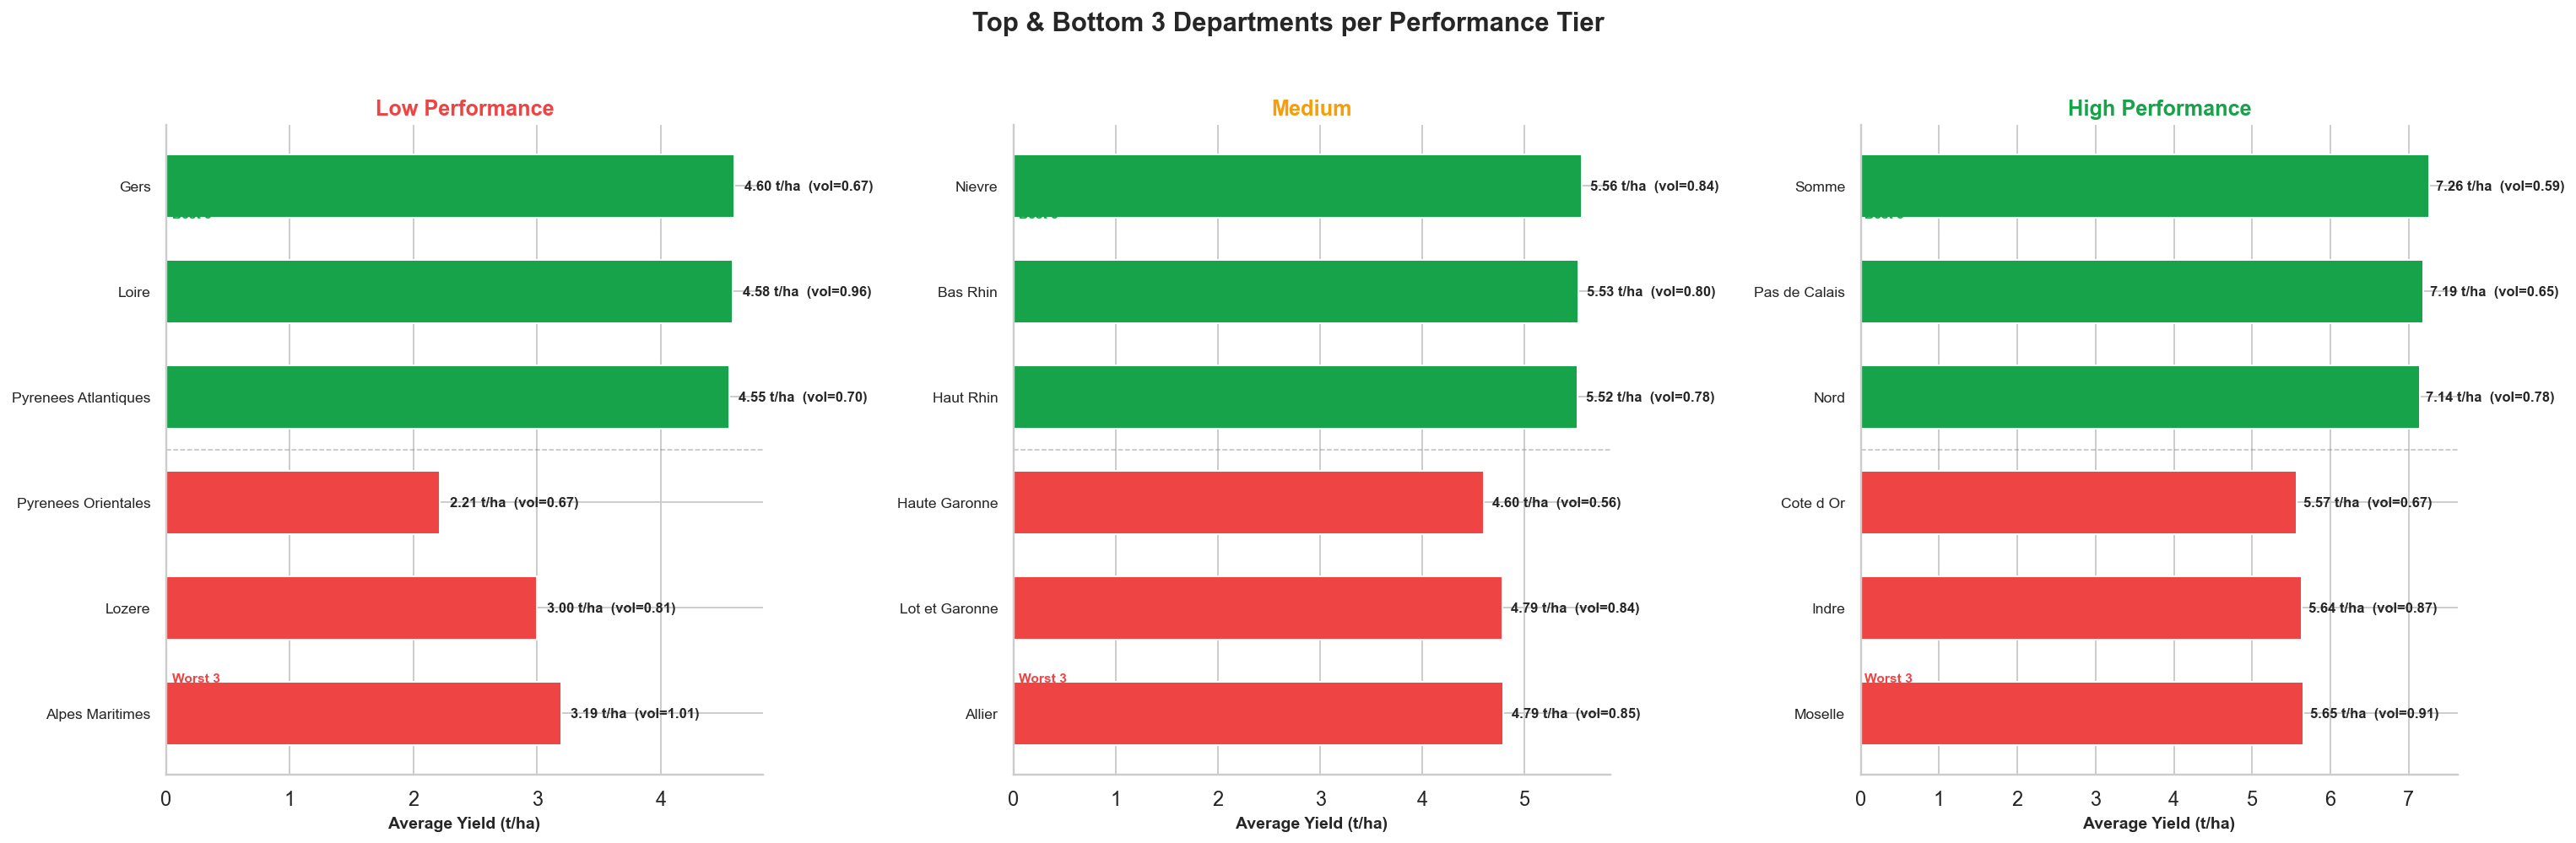

In [150]:
# Top and bottom departments per tier — with visualization
print("=" * 72)
print("  TOP & BOTTOM DEPARTMENTS PER TIER")
print("=" * 72)
for tier in TIERS:
    sub = dept[dept["tier"] == tier].copy()
    best = sub.nlargest(3, "avg_yield")
    worst = sub.nsmallest(3, "avg_yield")
    print(f"\n  {tier.upper()} (median yield: {sub['avg_yield'].median():.2f} t/ha)")
    print("    Best 3:")
    for _, r in best.iterrows():
        print(f"      {r['department']:30s}  yield={r['avg_yield']:.2f}  vol={r['volatility']:.2f}")
    print("    Worst 3:")
    for _, r in worst.iterrows():
        print(f"      {r['department']:30s}  yield={r['avg_yield']:.2f}  vol={r['volatility']:.2f}")
print("=" * 72)

# ── Visualization: horizontal grouped bar chart ──
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=False)

for ax, tier in zip(axes, TIERS):
    sub = dept[dept["tier"] == tier].copy()
    best3 = sub.nlargest(3, "avg_yield").sort_values("avg_yield")
    worst3 = sub.nsmallest(3, "avg_yield").sort_values("avg_yield", ascending=False)
    
    # Combine: worst at top, best at bottom
    combined = pd.concat([worst3, best3])
    labels = [d.replace("_", " ") for d in combined["department"]]
    yields = combined["avg_yield"].values
    vols   = combined["volatility"].values
    
    # Colors: red for worst, green for best
    colors = [TIER_COLORS["Low Performance"]] * 3 + [TIER_COLORS["High Performance"]] * 3
    
    bars = ax.barh(range(len(labels)), yields, color=colors, edgecolor="white", height=0.6)
    
    # Add yield + volatility labels on bars
    for i, (y, v) in enumerate(zip(yields, vols)):
        ax.text(y + 0.08, i, f"{y:.2f} t/ha  (vol={v:.2f})",
                va="center", fontsize=8.5, fontweight="bold")
    
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel("Average Yield (t/ha)", fontsize=10)
    ax.set_title(f"{tier}", fontsize=13, fontweight="bold",
                 color=TIER_COLORS[tier])
    
    # Add a separator line between worst and best
    ax.axhline(2.5, color="grey", linewidth=0.8, linestyle="--", alpha=0.5)
    ax.text(ax.get_xlim()[0] + 0.05, 4.7, "Best 3", fontsize=8, 
            color=TIER_COLORS["High Performance"], fontweight="bold")
    ax.text(ax.get_xlim()[0] + 0.05, 0.3, "Worst 3", fontsize=8, 
            color=TIER_COLORS["Low Performance"], fontweight="bold")
    
    # Clean up
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Top & Bottom 3 Departments per Performance Tier",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


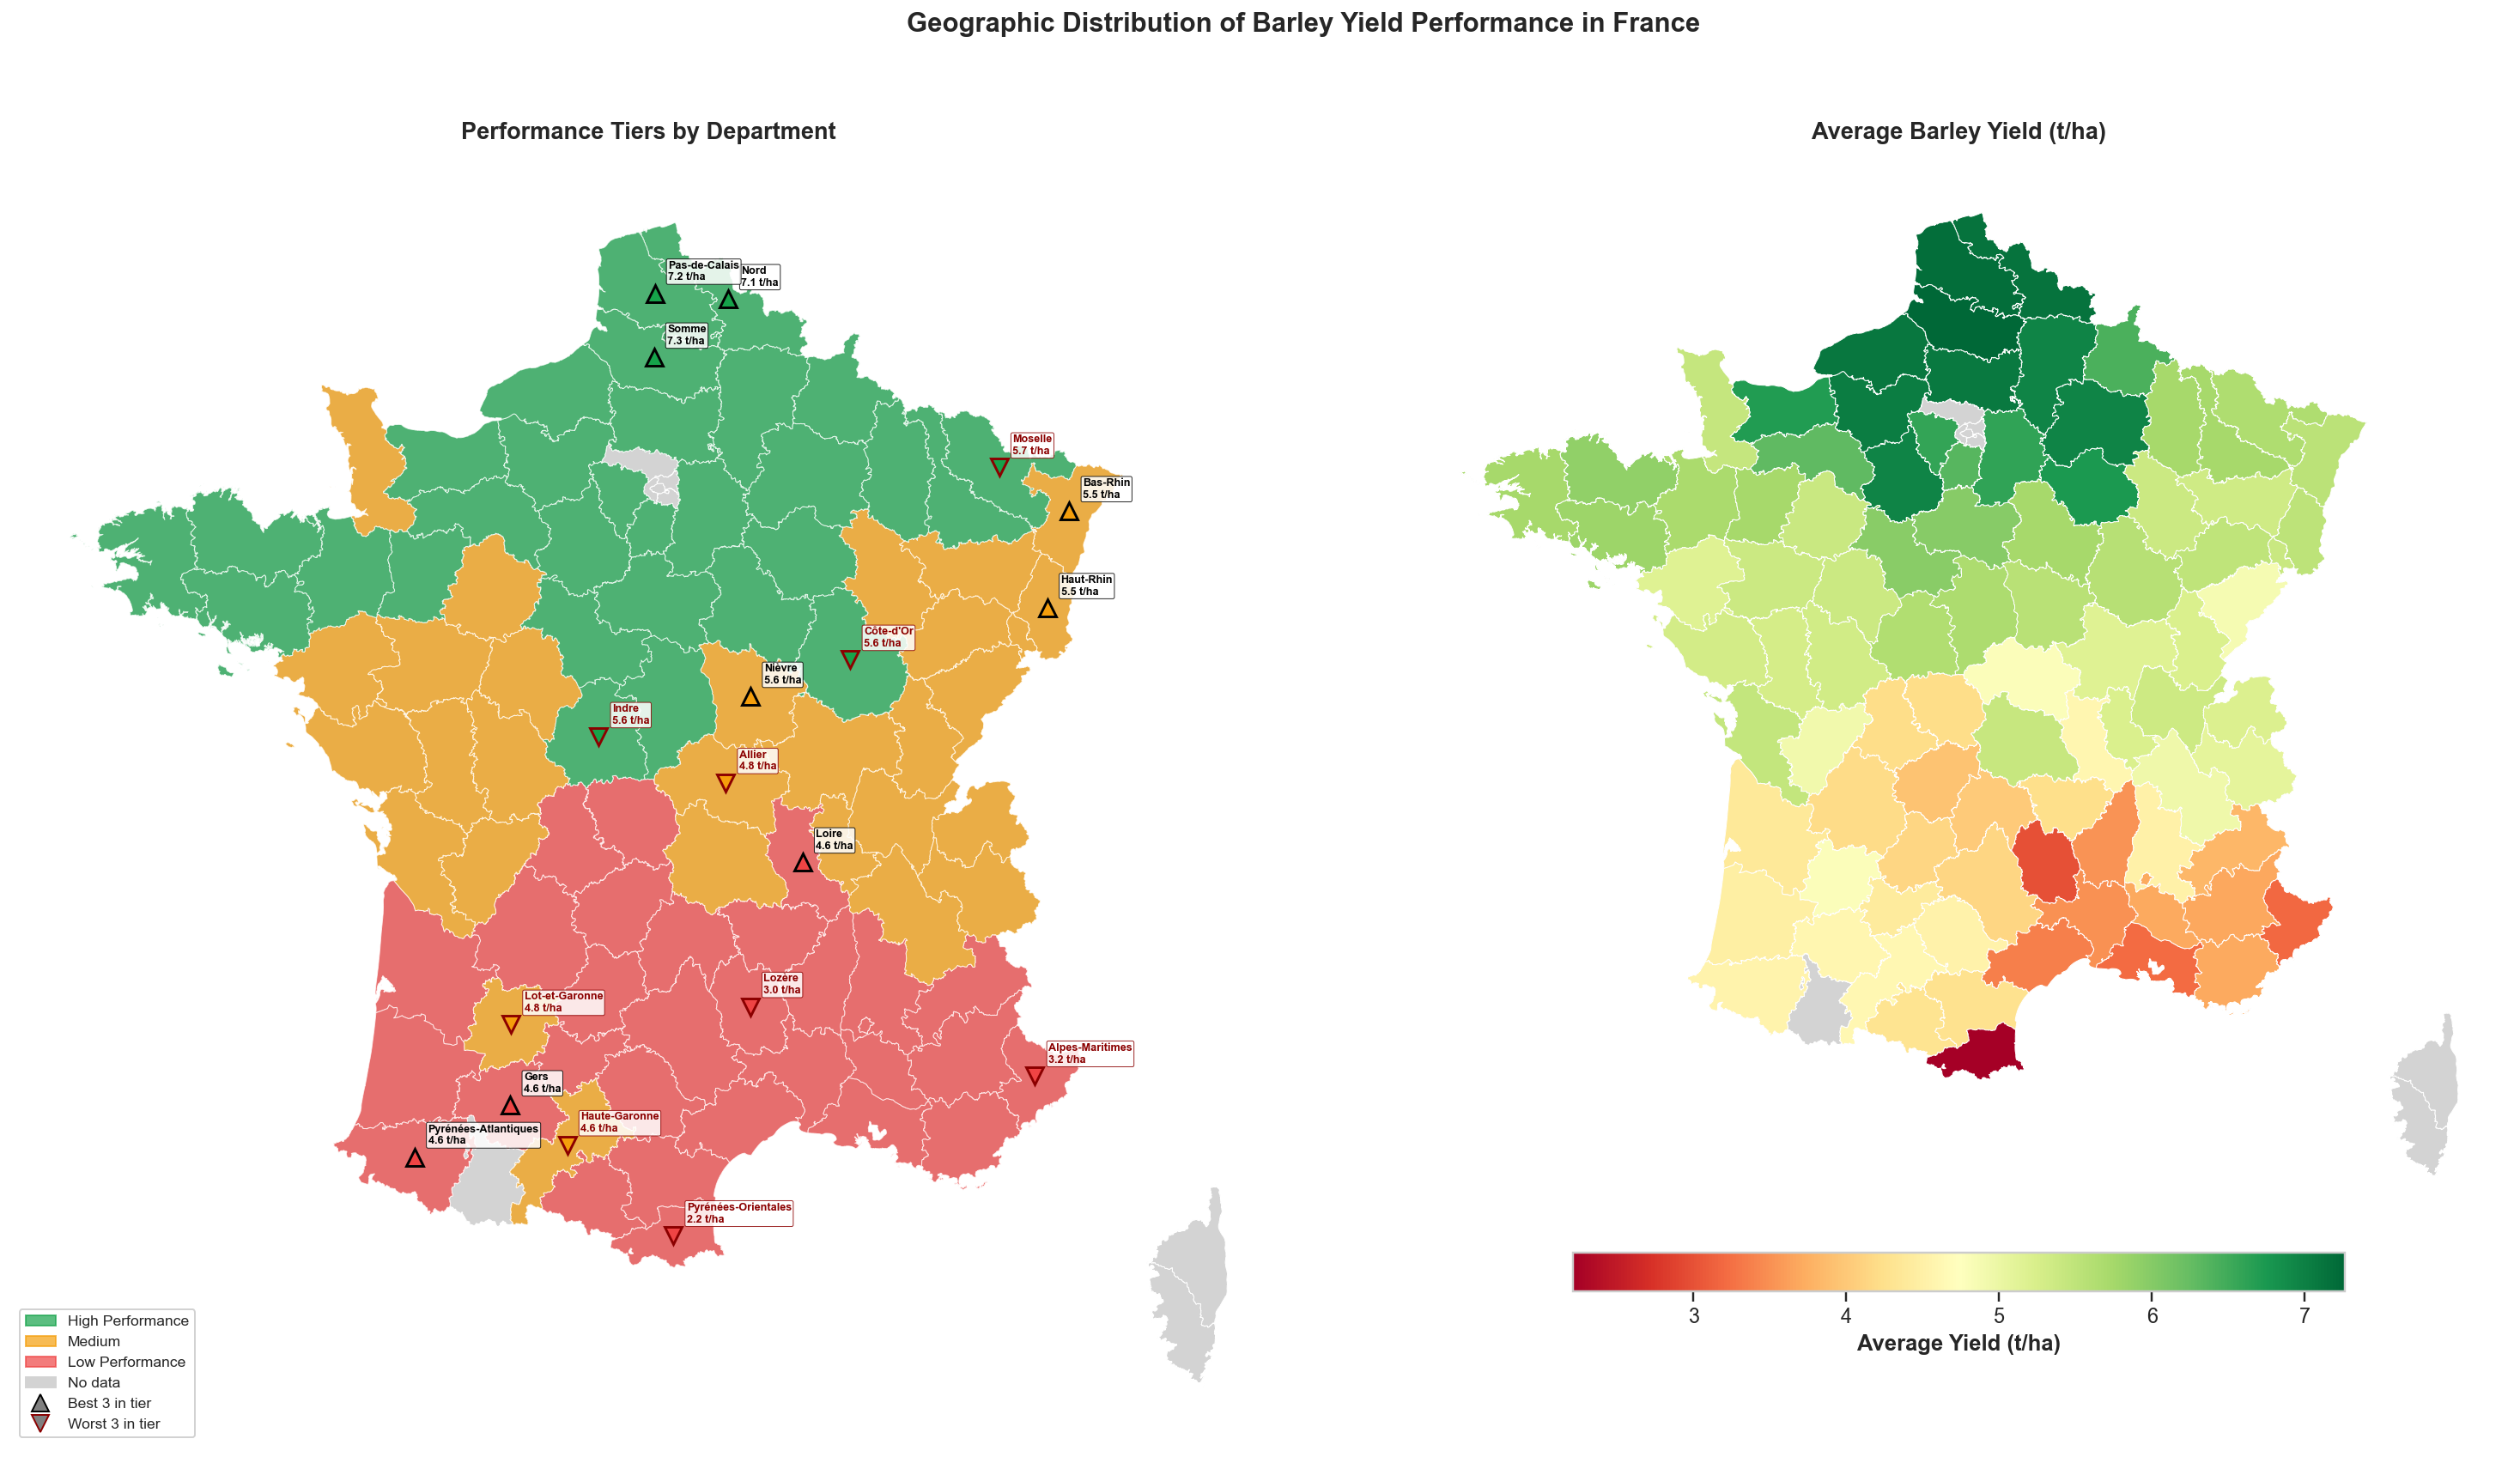

In [151]:
# ── Geographic Map (GeoPandas) ──
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import unicodedata

# Load France departments shapefile
geo = gpd.read_file("france_departments.geojson")

def normalize_name(name):
    nfkd = unicodedata.normalize('NFKD', name)
    ascii_name = ''.join(c for c in nfkd if not unicodedata.combining(c))
    return ascii_name.replace("-", "_").replace("'", "_").replace(" ", "_")

geo["dept_match"] = geo["nom"].apply(normalize_name)

# Merge with dept summary (already computed above)
geo_merged = geo.merge(dept, left_on="dept_match", right_on="department", how="left")

# Identify best/worst 3 per tier
highlight_map = {}
for tier in TIERS:
    sub = dept[dept["tier"] == tier]
    for idx in sub.nlargest(3, "avg_yield").index:
        highlight_map[dept.loc[idx, "department"]] = "best"
    for idx in sub.nsmallest(3, "avg_yield").index:
        highlight_map[dept.loc[idx, "department"]] = "worst"
geo_merged["highlight"] = geo_merged["dept_match"].map(highlight_map)

# ── Plot ──
fig, axes = plt.subplots(1, 2, figsize=(22, 12))

fig.suptitle("Geographic Distribution of Barley Yield Performance in France",
             fontsize=16, fontweight="bold", y=1.01)

# Left panel: tier choropleth
ax1 = axes[0]
geo.plot(ax=ax1, color="lightgrey", edgecolor="white", linewidth=0.5)
for tier, color in TIER_COLORS.items():
    geo_merged[geo_merged["tier"] == tier].plot(ax=ax1, color=color, edgecolor="white", linewidth=0.5, alpha=0.7)

for _, row in geo_merged[geo_merged["highlight"].notna()].iterrows():
    centroid = row.geometry.centroid
    role = row["highlight"]
    edge = "black" if role == "best" else "darkred"
    marker = "^" if role == "best" else "v"
    ax1.plot(centroid.x, centroid.y, marker=marker, color=TIER_COLORS.get(row["tier"], "grey"),
             markersize=10, markeredgecolor=edge, markeredgewidth=1.5, zorder=5)
    ax1.annotate(f"{row['nom']}\n{row['avg_yield']:.1f} t/ha",
        (centroid.x, centroid.y), textcoords="offset points", xytext=(8, 8),
        fontsize=6.5, fontweight="bold", color=edge, zorder=6,
        bbox=dict(boxstyle="round,pad=0.15", facecolor="white", alpha=0.85, edgecolor=edge, linewidth=0.5))

legend_elements = [
    mpatches.Patch(color=TIER_COLORS["High Performance"], alpha=0.7, label="High Performance"),
    mpatches.Patch(color=TIER_COLORS["Medium"], alpha=0.7, label="Medium"),
    mpatches.Patch(color=TIER_COLORS["Low Performance"], alpha=0.7, label="Low Performance"),
    mpatches.Patch(color="lightgrey", label="No data"),
    Line2D([0], [0], marker="^", color="w", markerfacecolor="grey", markersize=10, markeredgecolor="black", label="Best 3 in tier"),
    Line2D([0], [0], marker="v", color="w", markerfacecolor="grey", markersize=10, markeredgecolor="darkred", label="Worst 3 in tier"),
]
ax1.legend(handles=legend_elements, loc="lower left", fontsize=9, framealpha=0.9)
ax1.set_title("Performance Tiers by Department", fontsize=14, fontweight="bold", pad=15)
ax1.axis("off")

# Right panel: yield heatmap
ax2 = axes[1]
geo.plot(ax=ax2, color="lightgrey", edgecolor="white", linewidth=0.5)
geo_yield = geo_merged[geo_merged["avg_yield"].notna()]
geo_yield.plot(ax=ax2, column="avg_yield", cmap="RdYlGn", edgecolor="white", linewidth=0.5,
    legend=True, legend_kwds={"label": "Average Yield (t/ha)", "shrink": 0.6, "orientation": "horizontal", "pad": 0.02})
ax2.set_title("Average Barley Yield (t/ha)", fontsize=14, fontweight="bold", pad=15)
ax2.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


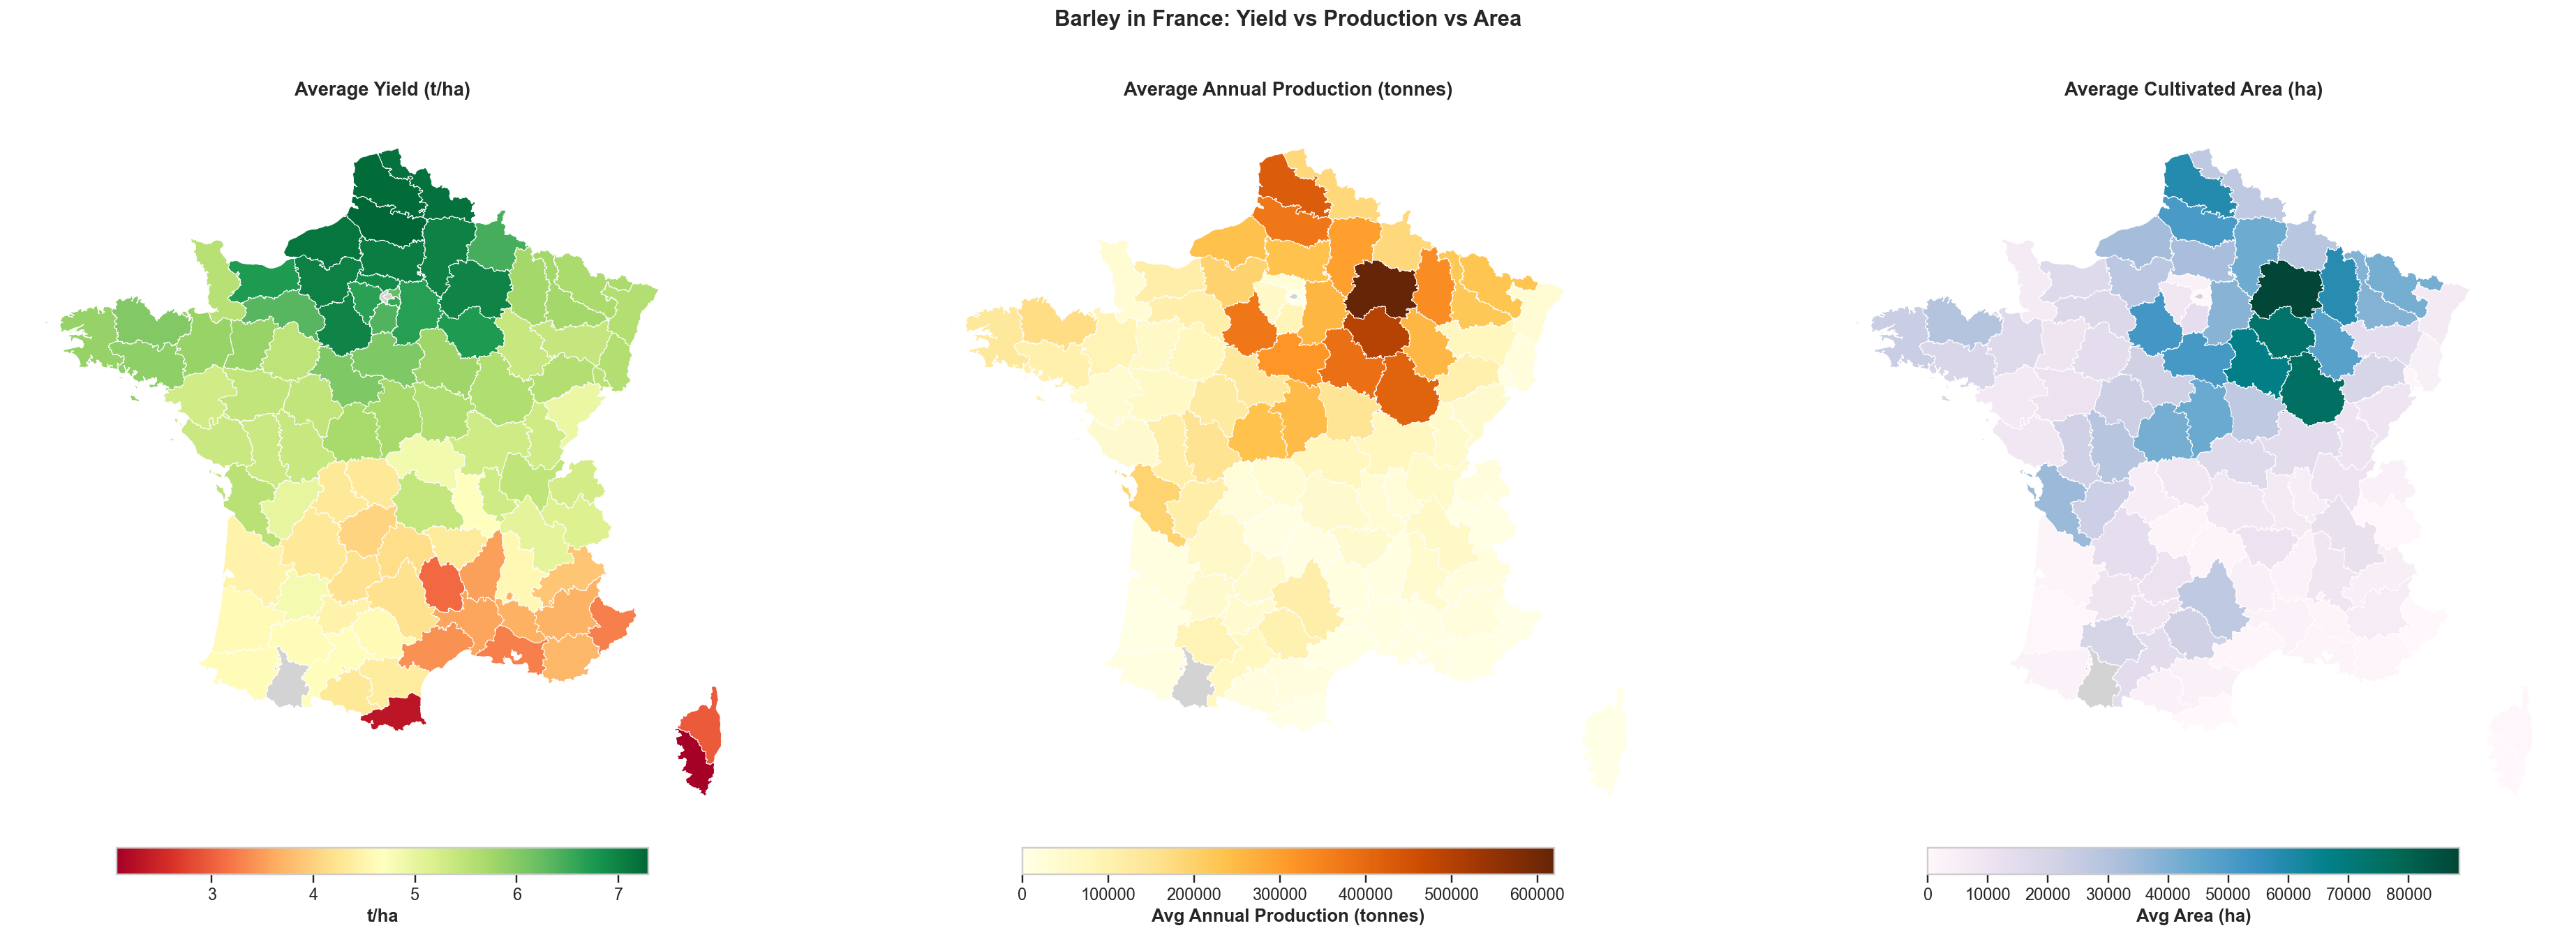


──────────────────────────────────────────────────
  YIELD (t/ha)
  Top 3:     Somme (7.30 t/ha) | Pas_de_Calais (7.24 t/ha) | Nord (7.19 t/ha)
  Bottom 3:  Corse_du_Sud (2.07 t/ha) | Pyrenees_Orientales (2.30 t/ha) | Haute_Corse (2.95 t/ha)

──────────────────────────────────────────────────
  PRODUCTION (tonnes)
  Top 3:     Marne (619,131 t) | Aube (497,354 t) | Pas_de_Calais (425,818 t)
  Bottom 3:  Hauts_de_Seine (0 t) | Corse_du_Sud (74 t) | Seine_Saint_Denis (126 t)

──────────────────────────────────────────────────
  AREA (ha)
  Top 3:     Marne (88,411 ha) | Cote_d_Or (75,454 ha) | Aube (73,547 ha)
  Bottom 3:  Hauts_de_Seine (0 ha) | Seine_Saint_Denis (19 ha) | Corse_du_Sud (41 ha)


In [152]:
# ── Yield vs Production vs Area Maps ──
import geopandas as gpd
import unicodedata

geo = gpd.read_file("france_departments.geojson")

def normalize_name(name):
    nfkd = unicodedata.normalize('NFKD', name)
    ascii_name = ''.join(c for c in nfkd if not unicodedata.combining(c))
    return ascii_name.replace("-", "_").replace("'", "_").replace(" ", "_")

geo["dept_match"] = geo["nom"].apply(normalize_name)

yield_raw = pd.read_csv("barley_yield_from_1982.csv", sep=";")
yield_raw = yield_raw.loc[:, ~yield_raw.columns.str.contains(r"^Unnamed", na=False)]
yield_raw["department"] = yield_raw["department"].astype(str).str.strip()

dept_full = (
    yield_raw.groupby("department")
    .agg(avg_yield=("yield", "mean"), avg_production=("production", "mean"), avg_area=("area", "mean"))
    .reset_index()
)
geo_prod = geo.merge(dept_full, left_on="dept_match", right_on="department", how="left")

fig, axes = plt.subplots(1, 3, figsize=(28, 10))
fig.suptitle("Barley in France: Yield vs Production vs Area",
             fontsize=16, fontweight="bold", y=1.01)

ax1 = axes[0]
geo.plot(ax=ax1, color="lightgrey", edgecolor="white", linewidth=0.5)
geo_prod[geo_prod["avg_yield"].notna()].plot(ax=ax1, column="avg_yield", cmap="RdYlGn",
    edgecolor="white", linewidth=0.5, legend=True,
    legend_kwds={"label": "t/ha", "shrink": 0.6, "orientation": "horizontal", "pad": 0.02})
ax1.set_title("Average Yield (t/ha)", fontsize=14, fontweight="bold", pad=15)
ax1.axis("off")

ax2 = axes[1]
geo.plot(ax=ax2, color="lightgrey", edgecolor="white", linewidth=0.5)
geo_prod[geo_prod["avg_production"].notna()].plot(ax=ax2, column="avg_production", cmap="YlOrBr",
    edgecolor="white", linewidth=0.5, legend=True,
    legend_kwds={"label": "Avg Annual Production (tonnes)", "shrink": 0.6, "orientation": "horizontal", "pad": 0.02})
ax2.set_title("Average Annual Production (tonnes)", fontsize=14, fontweight="bold", pad=15)
ax2.axis("off")

ax3 = axes[2]
geo.plot(ax=ax3, color="lightgrey", edgecolor="white", linewidth=0.5)
geo_prod[geo_prod["avg_area"].notna()].plot(ax=ax3, column="avg_area", cmap="PuBuGn",
    edgecolor="white", linewidth=0.5, legend=True,
    legend_kwds={"label": "Avg Area (ha)", "shrink": 0.6, "orientation": "horizontal", "pad": 0.02})
ax3.set_title("Average Cultivated Area (ha)", fontsize=14, fontweight="bold", pad=15)
ax3.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print top/bottom 3 for each metric
for col, label, fmt in [
    ("avg_yield", "YIELD (t/ha)", lambda v: f"{v:.2f} t/ha"),
    ("avg_production", "PRODUCTION (tonnes)", lambda v: f"{v:,.0f} t"),
    ("avg_area", "AREA (ha)", lambda v: f"{v:,.0f} ha"),
]:
    print(f"\n{'─'*50}")
    print(f"  {label}")
    print(f"  Top 3:    ", " | ".join(f"{r['department']} ({fmt(r[col])})" for _, r in dept_full.nlargest(3, col).iterrows()))
    print(f"  Bottom 3: ", " | ".join(f"{r['department']} ({fmt(r[col])})" for _, r in dept_full.nsmallest(3, col).iterrows()))
